In [2]:
!pip install pandas tqdm scipy matplotlib torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.2/821.2 MB 7.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.6/199.6 KB 70.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 7.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 31.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 MB 12.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 24.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 25.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 23.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.3/89.3 KB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 16.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 10.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━

In [5]:
pip install omegaconf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 KB 2.4 MB/s eta 0:00:00
  Using cached antlr4_python3_runtime-4.9.3-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [2]:
%autreload 2

UsageError: Line magic function `%autreload` not found.


In [3]:
import torch

ckpt_path = "/root/.boltz/boltz2_conf.ckpt"

checkpoint = torch.load(ckpt_path, map_location="cpu", weights_only=False)

print("Top-level keys:")
print(checkpoint.keys())

# Explore model state dict keys
print("\nState dict keys (truncated):")
for k in list(checkpoint['state_dict'].keys())[:20]:  # Show first 20 keys
    print(k)

# If hyperparameters were saved
if 'hyper_parameters' in checkpoint:
    print("\nHyperparameters:")
    for k, v in checkpoint['hyper_parameters'].items():
        print(f"{k}: {v}")


Top-level keys:
dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers', 'hparams_name', 'hyper_parameters'])

State dict keys (truncated):
input_embedder.atom_encoder.embed_atom_features.weight
input_embedder.atom_encoder.embed_atom_features.bias
input_embedder.atom_encoder.embed_atompair_ref_pos.weight
input_embedder.atom_encoder.embed_atompair_ref_dist.weight
input_embedder.atom_encoder.embed_atompair_mask.weight
input_embedder.atom_encoder.c_to_p_trans_k.1.weight
input_embedder.atom_encoder.c_to_p_trans_q.1.weight
input_embedder.atom_encoder.p_mlp.1.weight
input_embedder.atom_encoder.p_mlp.3.weight
input_embedder.atom_encoder.p_mlp.5.weight
input_embedder.atom_enc_proj_z.0.weight
input_embedder.atom_enc_proj_z.0.bias
input_embedder.atom_enc_proj_z.1.weight
input_embedder.atom_attention_encoder.atom_encoder.diffusion_transformer.layers.0.adaln.s_norm.weight
input_embedder.atom_attention_encoder.atom_enco

In [4]:
import sys
sys.path.append("/workspace/gfp_function_prediction")
sys.path.append("/workspace/gfp_function_prediction/boltz")

In [6]:
import sys
import os

# Add the parent directory to sys.path to import boltz
sys.path.append(os.path.join(os.getcwd(), '..'))

try:
    from src.boltz.model.models.boltz2 import Boltz2
    print("✅ Successfully imported Boltz2!")
except ImportError as e:
    print(f"❌ Failed to import Boltz2: {e}")
    print(f"Current sys.path: {sys.path}")

✅ Successfully imported Boltz2!


In [1]:
from pathlib import Path
from dataclasses import asdict, dataclass

In [9]:
from boltz.main import BoltzSteeringParams, Boltz2DiffusionParams, PairformerArgsV2, MSAModuleArgs
from boltz.model.models.boltz2 import Boltz2

In [17]:
from collections import defaultdict

class PairformerHookCollector:
    def __init__(self):
        self.hidden_reps = defaultdict(list)
        self.hooks = []

    def register_hooks(self, model):
        pairformer = (
            model.pairformer_module._orig_mod
            if getattr(model, "is_pairformer_compiled", False)
            else model.pairformer_module
        )

        def hook_fn(module, inputs, outputs):
            try:
                s, z = outputs
                self.hidden_reps["s"].append(s.detach().cpu())
                self.hidden_reps["z"].append(z.detach().cpu())
                print(f"[HOOK FIRED] s: {s.shape}, z: {z.shape}")
            except Exception as e:
                print(f"[HOOK ERROR] {e}")

        self.hooks.append(pairformer.register_forward_hook(hook_fn))

    def get(self):
        return dict(self.hidden_reps)

    def clear(self):
        self.hidden_reps.clear()

    def remove(self):
        for h in self.hooks:
            h.remove()


## Analysis Effective Strain 

In [2]:
import numpy as np
import pandas as pd
import os 
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
# es data:
es_path = Path('/workspace/gfp_function_prediction/data/0801_17_es')
gfp_dataset_path = Path('/workspace/gfp_function_prediction/data/raw_data/amino_acid_genotypes_to_brightness.tsv')
index_path = Path('/workspace/gfp_function_prediction/data/20250731_203124_subsample/balanced_subset.txt')

In [7]:
gfp_dataset = pd.read_csv(gfp_dataset_path, sep='\t')
gfp_dataset.head(10)

,aaMutations,uniqueBarcodes,medianBrightness,std
0,NaN,3645,3.719212,0.106992
1,SA108D,1,1.301030,NaN
2,SA108D:SN144D:SI186V:SM231T:SL234P,1,1.301031,NaN
3,SA108D:SY141N:SH146L:SE220G,1,1.301189,NaN
4,SA108G,2,3.708478,0.020613
5,SA108G:SK138M:SR166C:SL234P,1,3.582764,NaN
6,SA108G:SK154E:SF163S:SL192Q:SL193P,1,1.499573,NaN
7,SA108G:SK156R,1,3.659013,NaN
8,SA108G:SK156R:SI159V:SI186V:ST223S,1,3.573855,NaN
9,SA108P:SK111R:SG172S:SL176P:SS200G,1,1.301031,NaN


In [8]:
filter_df = pd.read_csv(index_path, sep="\t")
filter_df.head()

,idx,n_mut
0,15081,2
1,39424,2
2,18721,2
3,38687,2
4,10563,2


In [24]:
filter_df['idx'].values[884]

np.int64(13550)

In [9]:
indices_to_keep = filter_df['idx'].values

# Filter df_main by its index
filtered_df = gfp_dataset.loc[gfp_dataset.index.isin(indices_to_keep)]

In [26]:
filtered_df.head()

,aaMutations,uniqueBarcodes,medianBrightness,std
6,SA108G:SK154E:SF163S:SL192Q:SL193P,1,1.499573,NaN
12,SA108S:SE130G,1,3.767735,NaN
101,SA35G:ST57P:SC68R:SI134T:SN168S,1,1.593824,NaN
146,SA35T:SN157S,1,3.558076,NaN
160,SA35T:SV53M:SP73S:SM76L:SN133D:SL219P,1,1.302215,NaN


In [27]:
filtered_df['medianBrightness'].values[884]

np.float64(1.85932208878)

In [11]:
# Step 1: Load idx list
idx_list = filter_df['idx'].astype(str).tolist()

# Step 2: Set path to folder of CSV files
csv_folder = es_path

# Step 3: Collect filtered data
filtered_data = []

for idx in idx_list:
    filename = f"seq_{idx.zfill(5)}.csv"  # pad with zeros to match format
    file_path = csv_folder / filename

    if file_path.exists():
        df = pd.read_csv(file_path, usecols=["residue_index", "protA_resname", "protB_resname", "strain"])
        # Optionally add file index
        df["file_idx"] = int(idx)
        filtered_data.append(df[["residue_index", "strain"]].values)
    else:
        print(f"File not found: {file_path}")

# Step 4: Stack into array (n, L, 2)
final_array = np.stack(filtered_data)  # shape (n, L, 2)

# Optionally create a DataFrame version
final_df = pd.concat([
    pd.DataFrame(arr, columns=["residue_index", "strain"]).assign(file_idx=idx_list[i])
    for i, arr in enumerate(filtered_data)
])

In [13]:
import scipy

In [14]:
correlation_pos = []
for i in tqdm(range(final_array.shape[1])):
    correlation_pos.append(scipy.stats.pearsonr(final_array[:, i, 1], filtered_df['medianBrightness'].values))


100%|██████████| 238/238 [00:00<00:00, 551.74it/s]


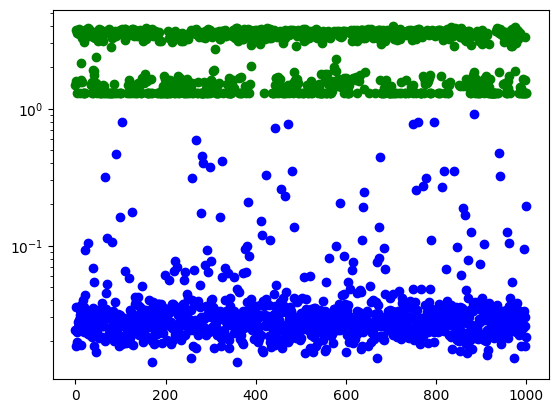

In [15]:
from turtle import color


plt.figure()
plt.scatter(y=filtered_df['medianBrightness'].values, x=np.arange(filtered_df['medianBrightness'].values.shape[0]), color='g')
plt.scatter(y=final_array[:, 57, 1], x=np.arange(final_array[:, 57, 1].shape[0]), color='b')
plt.yscale('log')
plt.show()

In [59]:
import scipy

In [62]:
scipy.stats.pearsonr(final_array[:, 57, 1], filtered_df['medianBrightness'].values)

PearsonRResult(statistic=np.float64(0.03381930920638052), pvalue=np.float64(0.28484485015629946))

In [16]:
corrs = np.stack(correlation_pos, 0)

In [17]:
np.argmax(corrs, 0)

array([74, 37])

In [21]:
final_array[:, 57, 1].argmax()

np.int64(884)

In [18]:
corrs[74]

array([0.06206207, 0.04953265])